### 🔍 Confidence Metric for Hotspots

When the model predicts a cell as a hotspot, we want to estimate **how confident it is** about that prediction — even **without access to future ground truth values**. For this, we propose a practical confidence metric that relies exclusively on **the size of the predicted interval**, which captures the model's **uncertainty**.

---

#### 📐 Proposed Formula (operational spatio-temporal version):

Confidence(t, r, c) = 1 - NormalizedIntervalWidth(t, r, c)

Where:

- `NormalizedIntervalWidth(t, r, c)` is the width of the prediction interval at time `t` and cell `(r, c)`, **rescaled between 0 and 1** using the min-max range over the full dataset.

The resulting confidence score is also bounded in \([0, 1]\), where higher values indicate **greater certainty** (i.e., narrower predicted intervals).

---

#### 🧠 Interpretation:

- **High confidence (~1):** the predicted interval is narrow → the model is confident in its estimate.
- **Low confidence (~0):** the predicted interval is wide → the model is uncertain and cautious.

This metric is fully compatible with deployment scenarios where no true crime values are yet available, and supports **risk-based prioritization of hotspot areas** based on prediction reliability.


### 📊 Visualizing Hotspot Confidence Across Space and Categories
We compute and visualize the average confidence per cell over time based on interval width alone. This spatial representation supports strategic hotspot prioritization

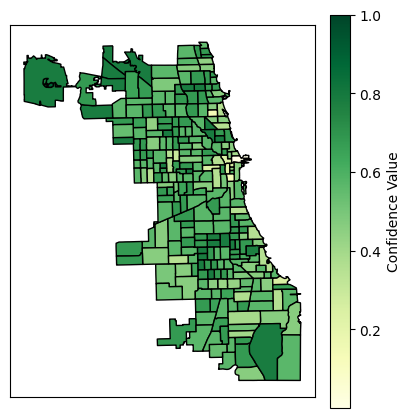

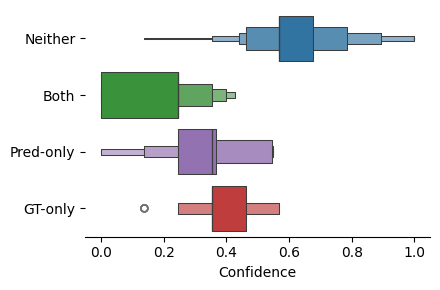

0.6048616749009764 0.15894319943657986


Confidence          
                         mean       std
Hotspot Match Type                     
Both                 0.231955  0.160464
GT-only              0.495178  0.107096
Neither              0.622403  0.143976
Pred-only            0.327252  0.131674

In [21]:
# Compute confidence using normalized interval width only (no need for ground truth)
df_final = compute_spatiotemporal_confidence(df_final)

# Aggregate over time to get average confidence per cell
confidence_df = df_final.groupby(["row", "col"]).agg({"Confidence": "mean"}).reset_index()

# Convert to grid for visualization
confidence_grid, _ = predictions_to_grid(confidence_df,
                                         confidence_df["Confidence"],
                                         confidence_df["Confidence"],
                                         grid_size,
                                         aggregate=False)

df_confidence = grid_to_dataframe(confidence_grid, coord_to_beat_map, value_name="confidence")

# Plot spatial confidence map
plot_prediction_maps(
    gdf[["beat_num", "geometry"]],
    [df_confidence],
    columns=["confidence"],
    titles=[""],
    cmap="YlGn",
    share_colorbar=True,
    # suptitle="Hotspot Confidence per Cell",
    figsize=(4, 5),
    edgecolor="black",
    vmin=None,
    vmax=None,
    colorbar_labels=["Confidence Value"],
    save_path="../../results/figures/confidence_map.png"
)

# Boxplot of confidence across hotspot types (excluding uncovered intervals)


g = sns.catplot(
    data=df_final[~df_final["Outside Interval"]],
    x="Confidence", y="Hotspot Match Type", 
    hue="Hotspot Match Type",
    kind="boxen",
    palette=palette,
    hue_order=hue_order,
    height=3, aspect=1.5  
)


for ax in g.axes.flat:
    for patch in ax.patches:
        patch.set_width(patch.get_width() / 2)  
        patch.set_x(patch.get_x() + patch.get_width())  

g.set_axis_labels("Confidence", "")  
g.despine(left=True)
plt.tight_layout()
plt.show()

g.savefig("../../results/figures/confidence_dist.pdf", format="pdf", bbox_inches="tight", dpi=300)
g.savefig("../../results/figures/confidence_dist.png", format="png", bbox_inches="tight", dpi=300)

# Print overall confidence statistics
print(df_confidence["confidence"].mean(), df_confidence["confidence"].std())
df_final.groupby(["Hotspot Match Type"]).agg({"Confidence":["mean","std"]})

# 📌 Historical Hotspot Frequency (Train)
We compute how often each cell was classified as a hotspot during the training period. This frequency will be used to guide hotspot prioritization in conjunction with the confidence metric.

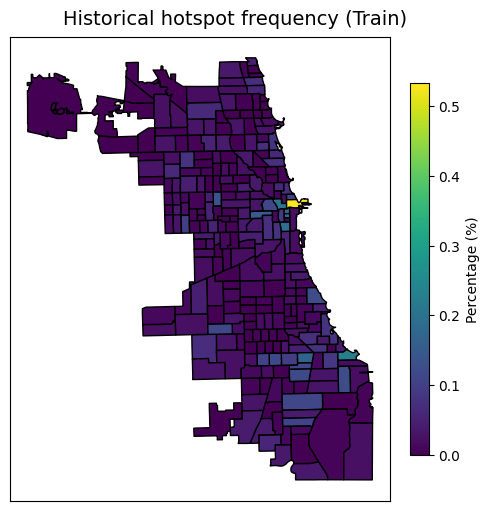

(np.float64(0.027681660899653977), np.float64(0.04818253923873735))

In [22]:
from src.utils.spatial_processing import define_hotspot_by_crimes

# Convert training set to spatiotemporal grid
train_grid, _ = predictions_to_grid(
    df_train,
    df_train["count"],
    df_train["count"],
    grid_size,
    aggregate=False
)

# Count how many times each cell was a hotspot
true_mask = []
for i in range(train_days):
    true_mask.append(define_hotspot_by_crimes(train_grid[i], hotspot_percentage))

# Average across timesteps (i.e., fraction of time each cell was selected as hotspot)
true_mask = np.mean(true_mask, axis=0)

# Convert to GeoDataFrame for plotting
df_true_mask = grid_to_dataframe(true_mask, coord_to_beat_map, value_name="percentage")

# Plot spatial distribution of historical hotspot frequency
plot_prediction_maps(
    gdf[["beat_num", "geometry"]],
    [df_true_mask],
    columns=["percentage"],
    titles=[""],
    cmap="viridis",
    share_colorbar=True,
    suptitle="Historical hotspot frequency (Train)",
    figsize=(5, 5),
    edgecolor="black",
    vmin=None,
    vmax=None,
    colorbar_labels=["Percentage (%)"]
)

# Display average historical hotspot frequency
df_true_mask["percentage"].mean(), df_true_mask["percentage"].std()


### 🔍 **Hotspot Priority Classification: Scenarios and Interpretations**

We define a **priority map** that classifies cells based on two main components:

1. **Confidence Score (0–1)**  
   Reflects how certain the model is about its predictions.  
   Lower interval width → higher confidence.  

2. **Hotspot Intensity or Frequency (0–1)**  
   This second axis depends on the **data availability** and use case:

---

#### 🧪 **Scenario 1: Historical Frequency (Post-hoc Evaluation)**

Used for analysis on **test data** or retrospective evaluations.

- **Hotspot Frequency** = proportion of times a cell was a hotspot in the ground truth.
- Helps analyze model behavior over time and validate decision criteria.

| Category        | Frequency | Confidence | Color    | Interpretation                                                                 |
|----------------|-----------|-------------|----------|---------------------------------------------------------------------------------|
| 🟥 Priority     | High      | High        | Red      | Active area with strong statistical backing → top intervention priority.       |
| 🟧 Critical     | High      | Low         | Orange   | Active area but uncertain prediction → possible false positive.                |
| 🟨 Under Surveillance   | Low       | Low         | Yellow   | Rarely active, uncertain → requires monitoring for emerging threats.           |
| 🟩 Low Interest | Low       | High        | Green    | Inactive and confidently predicted → deprioritize.                             |

---

#### 🚨 **Scenario 2: Normalized Prediction (Real-Time Deployment)**

Used when only the **predicted values** and **intervals** are available — as in a real-world setting.

- **Predicted Intensity** = current predicted value for a cell, normalized over the grid.
- Enables on-the-fly prioritization **without needing future observations**.

| Category        | Normalized Prediction | Confidence | Color    | Interpretation                                                                 |
|----------------|------------------------|-------------|----------|---------------------------------------------------------------------------------|
| 🟥 Priority     | High                   | High        | Red      | Area expected to have high crime, with strong model certainty.                 |
| 🟧 Critical     | High                   | Low         | Orange   | Area with high predicted crime but low model certainty — may be volatile.      |
| 🟨 Under Surveillance   | Low                    | Low         | Yellow   | Low predicted crime, but the model is uncertain — monitor for anomalies.       |
| 🟩 Low Interest | Low                    | High        | Green    | Calm region with confident low prediction — lowest priority.                   |

---

### 🧠 **Why Two Scenarios?**

- Use **Scenario 1** to validate your framework using ground-truth test data.
- Use **Scenario 2** to **deploy in practice**, when future outcomes are unknown.

This flexibility ensures that the framework is **both evaluable and deployable**.

## 🗺️ Visualizing Hotspot Priority Maps

Based on the previously defined confidence scores and hotspot definitions, we generate **priority maps** for three key scenarios:

### 📊 Scenarios Evaluated

1. **Historical Frequency (Train)**  
   - Computes how often each cell was a hotspot during the training phase.  
   - Represents the empirical, post-hoc view of risk.

2. **Hotspot Prediction**  
   - Binary mask based on the output of the baseline NaiveCell model.  
   - Reflects which cells were predicted as hotspots overall.

3. **Punctual Prediction**  
   - Uses the magnitude of the predicted crime values per cell (normalized).  
   - Represents real-time predictive intensity.

Each scenario is combined with the **confidence grid** to assign a priority level to each cell:

| Category        | Risk Level        | Confidence | Color    | Description                                           |
|----------------|-------------------|------------|----------|-------------------------------------------------------|
| 🟥 Priority     | High              | High       | Red      | High-risk area with strong model support             |
| 🟧 Critical     | High              | Low        | Orange   | Risky area but low model confidence → attention needed |
| 🟨 Under Surveillance   | Low               | Low        | Yellow   | Infrequent but uncertain predictions → keep watch    |
| 🟩 Low Interest | Low               | High       | Green    | Quiet zone with confident low predictions            |

### 📌 Visualization Notes

- Each column below represents a different priority assignment strategy.
- Colors are **manually assigned** based on the classification output.
- The same **spatial geometry (police beats)** is used across maps for consistency.



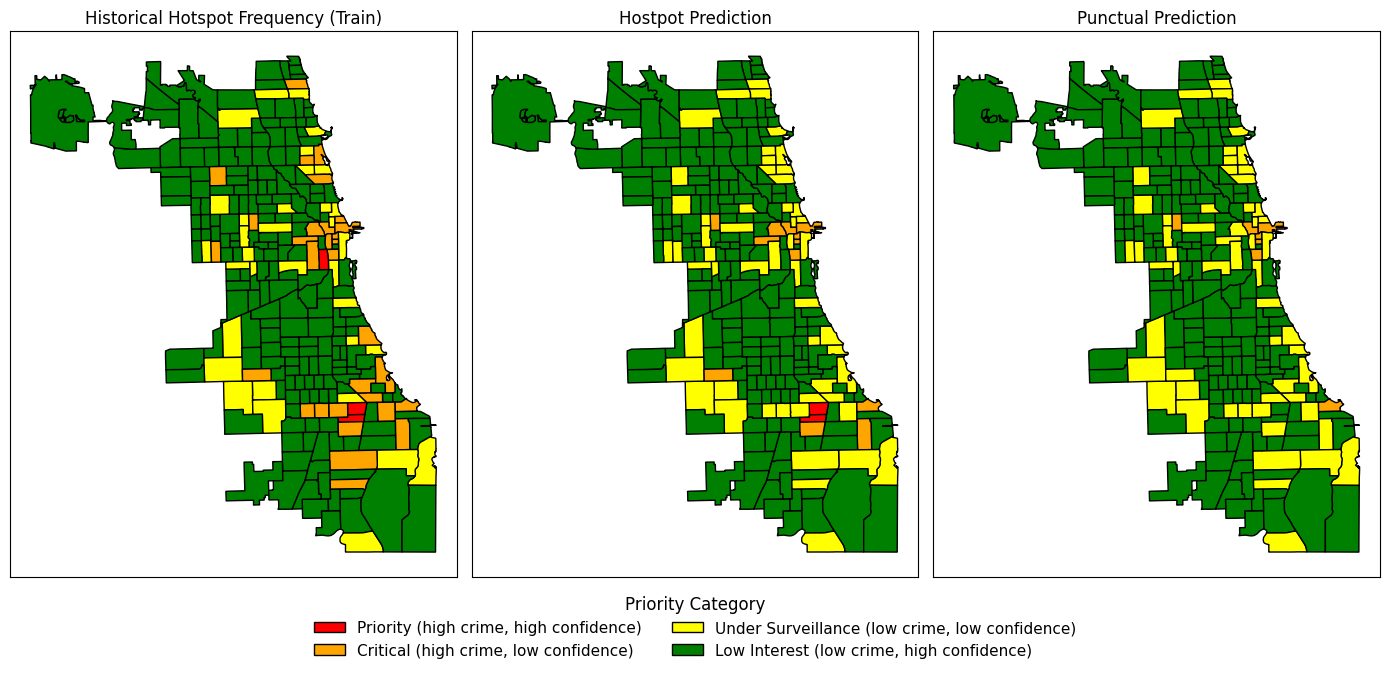

In [23]:
hotspots_dir="../../results/hotspots/real_data/Chicago/"
hotspot_naive = joblib.load(os.path.join(hotspots_dir,"naive_hotspot_prediction.pkl"))

Priority={
    "Historical Hotspot Frequency (Train)":{"base":true_mask,"base_type":"frequency","freq_thresh":0.07},
    "Hostpot Prediction": {"base":hotspot_naive,"base_type":"binary","freq_thresh":None},
    "Punctual Prediction": {"base":grid_pred,"base_type":"continuous","freq_thresh":0.6},
}

for i in Priority:
    category_grid, legend=hotspot_priority(
                                            confidence_grid,
                                            Priority[i]["base"],
                                            base_type=Priority[i]["base_type"],
                                            freq_thresh=Priority[i]["freq_thresh"],
                                            conf_thresh=0.5#confidence_grid.mean()
                                        )
    Priority[i]["P"]=category_grid

########## Save
for name, values in Priority.items():
    grid = values["P"]  
    file_name = name.lower().replace(" ", "_") + "_priority_naive.npy"
    np.save(os.path.join(hotspots_dir, file_name), grid)


from matplotlib.patches import Patch

# Diccionario de categorías a colores
category_colors = {
    "Priority (high crime, high confidence)": "red",
    "Critical (high crime, low confidence)": "orange",
    "Under Surveillance (low crime, low confidence)": "yellow",
    "Low Interest (low crime, high confidence)": "green"
}

# Lista de categorías en orden deseado (leyenda)
priority_labels = list(category_colors.keys())

# Figuras en columnas
fig, axes = plt.subplots(1, 3, figsize=(14, 7), sharex=True, sharey=True)

for ax, (title, priority_data) in zip(axes, Priority.items()):
    df_priority = grid_to_dataframe(priority_data["P"], coord_to_beat_map, value_name="priority")
    df_priority["priority"] = df_priority["priority"].replace(legend)
    gdf_plot = gdf[["beat_num", "geometry"]].merge(
        df_priority, how="left", left_on="beat_num", right_on="beat"
    )

    gdf_plot = gdf_plot[gdf_plot["priority"].notna()].copy()
    gdf_plot["color"] = gdf_plot["priority"].map(category_colors)

    gdf_plot.plot(
        color=gdf_plot["color"],
        ax=ax,
        edgecolor="black"
    )
    ax.set_title(title, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

# Crear elementos de leyenda
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=label)
    for label, color in category_colors.items()
]

# Leyenda inferior
fig.legend(
    handles=legend_elements,
    title="Priority Category",
    loc="lower center",
    frameon=False,
    ncol=2,
    fontsize=11,
    title_fontsize=12,
    bbox_to_anchor=(0.5, 0)
)

# fig.suptitle("Hotspot Priority Maps", fontsize=16)

plt.tight_layout(rect=[0, 0.10, 1, 0.95])
fig.savefig("../../results/figures/priority_maps.pdf", format="pdf", bbox_inches="tight", dpi=300)
fig.savefig("../../results/figures/priority_maps.png", format="png", bbox_inches="tight", dpi=300)
plt.show()


# ✅ Hotspot Priority Sensitivity Grid Generation
We explore how the priority classification and resulting hotspot masks change under varying thresholds of:

📈 Risk proxy (either historical frequency, binary hotspot prediction, or continuous predicted intensity)

📉 Prediction confidence

We build a comprehensive set of spatio-temporal hotspot masks for each configuration, to be evaluated later in a separate notebook.

In [24]:
import pickle


# Thresholds for exploration
freq_thresholds_hist = np.linspace(true_mask.min(), true_mask.max(), 10)
freq_thresholds_pred = np.linspace(grid_pred.min() / grid_pred.max(), 1.0, 10)
confidence_thresholds = np.linspace(0.10, 0.95, 10)

# Dictionary to store masks
hotspot_masks_results = {
    "Historical Hotspot Frequency (Train)": {},
    "Hostpot Prediction": {},
    "Punctual Prediction": {}
}

# Generate all combinations of hotspot priority masks
for scenario, params in Priority.items():

    if scenario == "Hostpot Prediction":
        for freq_thresh in freq_thresholds_pred:
            for conf_thresh in confidence_thresholds:
                category_grid, _ = hotspot_priority(
                    confidence_grid,
                    params["base"],
                    base_type=params["base_type"],
                    freq_thresh=freq_thresh,
                    conf_thresh=conf_thresh
                )
                key = f"freq_{freq_thresh:.2f}_conf_{conf_thresh:.2f}"
                hotspot_masks_results[scenario][key] = category_grid

    elif scenario == "Historical Hotspot Frequency (Train)":
        for freq_thresh in freq_thresholds_hist:
            for conf_thresh in confidence_thresholds:
                category_grid, _ = hotspot_priority(
                    confidence_grid,
                    params["base"],
                    base_type=params["base_type"],
                    freq_thresh=freq_thresh,
                    conf_thresh=conf_thresh
                )
                key = f"freq_{freq_thresh:.2f}_conf_{conf_thresh:.2f}"
                hotspot_masks_results[scenario][key] = category_grid

    elif scenario == "Punctual Prediction":
        for freq_thresh in freq_thresholds_pred:
            for conf_thresh in confidence_thresholds:
                category_grid, _ = hotspot_priority(
                    confidence_grid,
                    params["base"],
                    base_type=params["base_type"],
                    freq_thresh=freq_thresh,
                    conf_thresh=conf_thresh
                )
                key = f"freq_{freq_thresh:.2f}_conf_{conf_thresh:.2f}"
                hotspot_masks_results[scenario][key] = category_grid

# Save masks dictionary for later evaluation
file_name = "naive_hotspot_masks_sensitivity.pkl"
with open(os.path.join(hotspots_dir, file_name), "wb") as f:
    pickle.dump(hotspot_masks_results, f)
